# Parse

In [1]:
story_file = 'story.txt'
text_file = open("scene_text.txt", "w")

lines = [line.rstrip('\n') for line in open(story_file)]
scenes = ['yard','desert','castle','volcano','lagoon','garden'] # can add more
birds = ['David','Wendy','Alex','Ben']
features = ['This bird has a bright yellow body, with brown on its crown and wings.','This colorful bird has a bright yellow body, a black crown and tail.','This white bird has a black crown and yellow beak.','This blue bird has a blue crown and black tails.']


scenes_to_generate = []
birds_to_generate = []
for i in range(len(lines)):
    content = lines[i].split('.')
    scene_candidate = content[0].split(' ')
    scenes_to_generate.append( [w for w in scene_candidate if w in scenes][0] )
    
    temp_birds = []
    for j in range(len(content)-2): #first sentence and last space
        birds_candidate = content[j+1].split(' ') 
        temp_birds.append( [w for w in birds_candidate if w in birds][0])
    birds_to_generate.append(temp_birds)

for i in range(len(lines)):
    print scenes_to_generate[i], birds_to_generate[i]

for i in range(len(lines)):
    for j in range(len(birds_to_generate[i])):
        for k in range(len(birds)):
            if birds_to_generate[i][j] == birds[k]:
                text_file.write("%s\n" % features[k])
text_file.close()


yard ['David']
desert ['David', 'Alex']
castle ['David', 'Ben']
volcano ['David']
lagoon ['David', 'Wendy']
garden ['David', 'Wendy']


In [2]:
print scenes_to_generate

['yard', 'desert', 'castle', 'volcano', 'lagoon', 'garden']


# Scene

Loaded init code:  (1, 4096)
step: 0000	 max:  341 [0.22]	 obj:  204 [0.14]	 norm: [0.91]
step: 0001	 max:  204 [0.61]	 obj:  204 [0.61]	 norm: [0.37]
step: 0002	 max:  204 [0.85]	 obj:  204 [0.85]	 norm: [0.15]
step: 0003	 max:  204 [0.85]	 obj:  204 [0.85]	 norm: [0.11]
step: 0004	 max:  204 [0.96]	 obj:  204 [0.96]	 norm: [0.02]
step: 0005	 max:  204 [0.94]	 obj:  204 [0.94]	 norm: [0.05]
step: 0006	 max:  204 [0.98]	 obj:  204 [0.98]	 norm: [0.01]
step: 0007	 max:  204 [0.89]	 obj:  204 [0.89]	 norm: [0.08]
step: 0008	 max:  204 [0.98]	 obj:  204 [0.98]	 norm: [0.01]
step: 0009	 max:  204 [0.96]	 obj:  204 [0.96]	 norm: [0.03]
step: 0010	 max:  204 [0.96]	 obj:  204 [0.96]	 norm: [0.02]
step: 0011	 max:  204 [0.98]	 obj:  204 [0.98]	 norm: [0.01]
step: 0012	 max:  204 [0.93]	 obj:  204 [0.93]	 norm: [0.04]
step: 0013	 max:  204 [0.97]	 obj:  204 [0.97]	 norm: [0.01]
step: 0014	 max:  204 [0.98]	 obj:  204 [0.98]	 norm: [0.01]
step: 0015	 max:  204 [0.99]	 obj:  204 [0.99]	 norm: [0

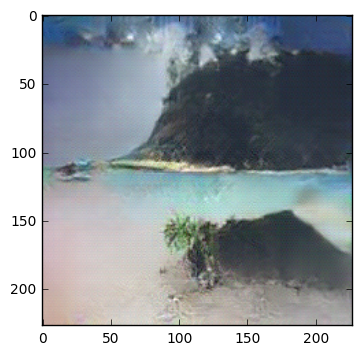

In [1]:
import os, sys
os.environ['GLOG_minloglevel'] = '2'    # suprress Caffe verbose prints
os.chdir("ppgn")

import caffe
import numpy as np
from numpy.linalg import norm
import scipy.misc, scipy.io
import argparse 
import util
import settings
from sampler import Sampler
from sampling_class import ClassConditionalSampler
from sampling_class import get_code
import settings
from conditional_sampling_from_real_image import conditional_sampling_from_real_image

# Index of neurons in fc layers or channels in conv layers
# from 0 to 364
units="204"       

label_to_name = {"8":"amusement_park.jpg",
                 "10":"aqueduct.jpg",
                 "12":"arch.jpg",
                 "84":"castle.jpg",
                 "91":"church.jpg",
                 "94":"cliff.jpg",
                 "117":"desert.jpg",
                 "204":"lagoon.jpg",
                 "209":"lawn.jpg",
                 "229":"water.jpg",
                 "230":"outdoor.jpg",
                 "232":"mountain.jpg",
                 "234":"mountain_snowy.jpg",
                 "350":"volcano.jpg",
                 "362":"yard.jpg",
                 "364":"garden.jpg"}

if units in label_to_name:
    img_name = label_to_name[units]
else:
    img_name = "defalut.jpg"
    
opt_layer="fc6"
act_layer="fc8"
xy=0              # Spatial position for conv layers, for fc layers: xy = 0

n_iters=100       # Run for N iterations
reset_every=0     # Reset the code every N iterations (for diversity)
save_every=5      # Save a sample every N iterations
lr=0.5 
lr_end=0.5        # Linearly decay toward this ending lr (e.g. for decaying toward 0, set lr_end = 1e-10)
threshold=0.      # Filter out samples below this threshold e.g. 0.98
seed=0

# -----------------------------------------------
# Multipliers in the update rule Eq.11 in the paper
# -----------------------------------------------
epsilon1=1e-5     # prior
epsilon2=1.       # condition
epsilon3=1e-17    # noise
epsilon4=0.
# -----------------------------------------------

# Start from a random code. To start from a real code, replace with a path e.g. "images/filename.jpg"
init_file="images/" + img_name

# Condition net
# net_weights="nets/caffenet/bvlc_reference_caffenet.caffemodel"
# net_definition="nets/caffenet/caffenet.prototxt"
net_weights="nets/placesCNN/alexnet_places365.caffemodel"
net_definition="nets/placesCNN/deploy_alexnet_places365.prototxt"

output_dir=("output/" + act_layer + "_chain_" + units + "_eps1_" + 
            str(epsilon1) + "_eps3_" + str(epsilon3))

# Default to constant learning rate
if lr_end < 0:
    lr_end = lr

encoder_definition = settings.encoder_definition
encoder_weights = settings.encoder_weights
generator_definition = settings.generator_definition
generator_weights = settings.generator_weights

output_image, _ = conditional_sampling_from_real_image(encoder_definition, encoder_weights,
					 generator_definition, generator_weights,
                     net_definition, net_weights,
                     units, xy,
                     n_iters,
                     reset_every,
                     save_every,
                     threshold,
                     epsilon1, epsilon2, epsilon3, epsilon4,
                     lr, lr_end,
                     seed,
                     opt_layer,
                     act_layer,
                     init_file,
                     output_dir)

import matplotlib.pyplot as plt
%matplotlib inline

filename = '../SR/input/scene.jpg'
util.save_image(output_image, filename)
img = output_image[:,::-1, :, :] # Convert from BGR to RGB
img = util.deprocess(img, in_range=(-120,120))
plt.imshow(img)
os.chdir("../")

# SR

Load model
 [*] Reading checkpoints...
DCGAN.model-3002
Finish!


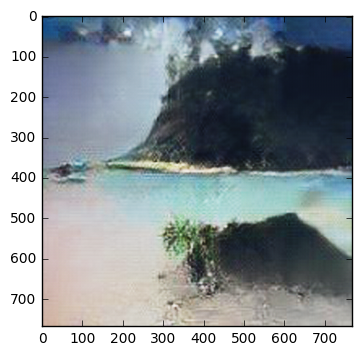

In [1]:
import os
os.chdir("SR")

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as  plt
%matplotlib inline


from sr import *

# initialization
sess, dcgan = super_resolution_initialize()

# super resolution (Can repeatly generate SR images without initialization)
img = super_resolution(sess, dcgan, './input/scene.jpg')

img_show = (img+1)/2  # normalize to 0~1
plt.imshow(img_show)
os.chdir("../")